In [2]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

In [5]:
mnist.data.shape

(70000, 784)

In [6]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

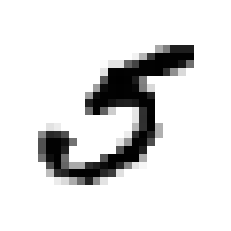

In [8]:
#We can plot the inputs to see what they look like
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")
plt.show()

In [9]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [10]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [11]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plt.show()

<Figure size 648x648 with 0 Axes>

In [12]:
y[36000]

5

In [13]:
#We seperate the training and test data, in MNIST the last 10k inputs are already set apart for the test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
#We shuffle the training set to guarantee that all cross-validation fold will be similar. 
#Some learning algorithms are sensitive to order of training so shuffling can avoid poor performance due to having
#many similar instances in a row. In some cases where time series is important shuffling should be avoided.
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Binary classifier

In [15]:
#We start by simplifying the problem into a binary one. We only try to classify wether a number is '5'
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [17]:
sgd_clf.predict([some_digit])

array([ True])

In [18]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [19]:
#In some cases a manual implementation of K fold cross validation can be useful to be able to modify it for a specific use
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96225
0.9645
0.94765


In [20]:
#The above code shows very high accuracy for our classifier. Below we demonstrate that this is due to a skewed dataset where
#only about 10% of digits are 5s so always guessing not 5 yields 90% accuracy. 
#Accuracy is generally not the preffered performance measure for classifiers, especially when dealing with skewed datasets


from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [21]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [22]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [23]:
from sklearn.metrics import confusion_matrix
#the confusion matrix format is:
# True Negative (correctly classified as non 5) - False Positive (wrongly classified as 5s)
# False Negative (wrongly classified as non 5s)- True Positive (correctly classified as 5s)
confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]])

In [24]:
y_train_perfect_predictions = y_train_5

In [25]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [26]:
from sklearn.metrics import precision_score, recall_score
#precision = TP/(TP+FP)
precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [27]:
#recall = TP/(TP+FN) is the ratio of positive instances that are correctly detected by the classifier
recall_score(y_train_5, y_train_pred)

0.7509684560044272

In [28]:
#To combine precision and recall into a single metric we can use the f1 score, which is the harmonic mean 
#of precision and recall. It gives much more weight to low values so the classifier will only get a high
#f1 score if both recall and precision are high
from sklearn.metrics import f1_score
#f1 = precision*recall/(precision+recall)=TP/(TP+(FN+TP)/2)
f1_score(y_train_5, y_train_pred)
#F1 score favors clasiffiers that have similar precision and recall, which is not always a desired attribute.

0.7642200112633752

In [29]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([150526.40944343])

In [30]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [31]:
y_some_digit_pred

array([ True])

In [32]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [33]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [34]:
y_scores.shape

(60000,)

In [35]:
#To decide which threshold suits our need the best we can plot the threshold and recall curves
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

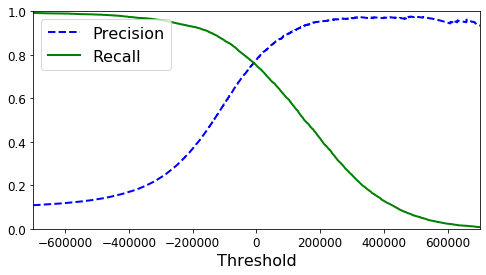

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [37]:
(y_train_pred == (y_scores > 0)).all()

True

In [38]:
#To make predictions instead of calling predict() in order to specify a threshold we can run the code below:
y_train_pred_90 = (y_scores > 70000)

In [39]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

In [40]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

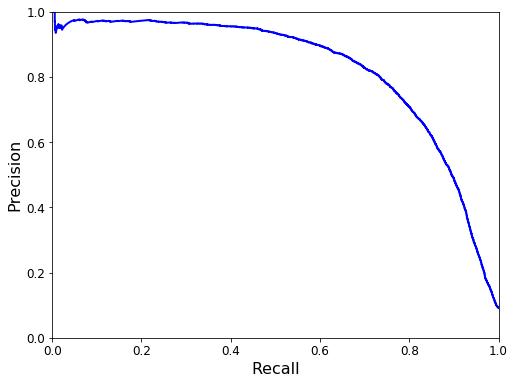

In [41]:
#Another way to visualize the precision and recall tradeoffs is to plot them against each other like below:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

# ROC curves



One way to compare classifiers is to measure the area under the curce, the higher it is, the better as a perfect classifier
has an auc of 1.
To decide wether to use the precision/recall curve or the ROC curve a good rule of thumb is, you should prefere PR
curve whenever the positive class is rare or when you care more about the false positives than the false negatives
and the ROC curve otherwise.



In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

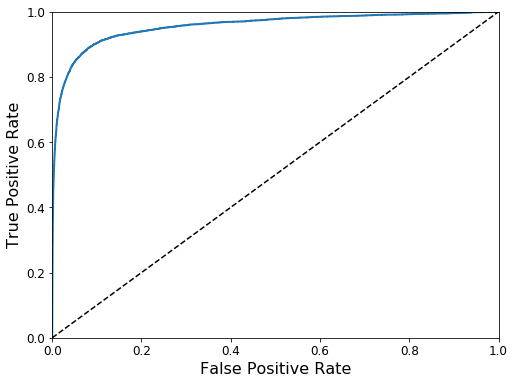

In [43]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()




In [44]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9562435587387078

In [45]:
#Train a RandomForestClassifier to compare performance to SGD
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [46]:
#We need to convert the probabilities given from the RandomForestClassifier into score to be able to plot 
#the ROC curve 
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

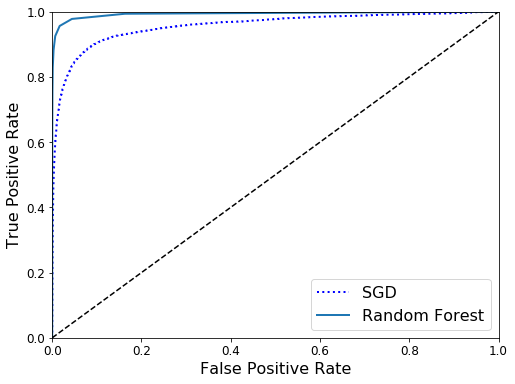

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [48]:
#AUC is much higher for Random Forest
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [49]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [50]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# Multiclass classification

In [51]:
#Scikit learn automatically recognizes and implements multicall classificiation for sgd which is normally a 
#binary classifier. To do so it trains 10 binary classifiers, get their decision scores for the image, and 
#selects the class with the highest score
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [52]:
#We can each class' score
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-152619.46799791, -441052.22074349, -249930.3138537 ,
        -237258.35168498, -447251.81933158,  120565.05820991,
        -834139.15404835, -188142.48490477, -555223.79499145,
        -536978.92518594]])

In [53]:
np.argmax(some_digit_scores)

5

In [54]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [55]:
sgd_clf.classes_[5]

5

In [56]:
#We can also force scikitlearn to use one-versus-one or one-versus-all
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [57]:
#Using OvO method yields N*(N-1)/2 different classifiers
len(ovo_clf.estimators_)

45

In [58]:
#We can also train random forest model the same way
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [59]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84993001, 0.81769088, 0.84707706])

In [61]:
#We can see the accuracy above which is not bad but we can do better. For example simply 
#scaling the inputs brings the accuracy over 90% for every fold
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91211758, 0.9099955 , 0.90643597])

In [62]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5749,    4,   22,   11,   11,   40,   36,   11,   36,    3],
       [   2, 6490,   43,   24,    6,   41,    8,   12,  107,    9],
       [  53,   42, 5330,   99,   87,   24,   89,   58,  159,   17],
       [  46,   41,  126, 5361,    1,  241,   34,   59,  129,   93],
       [  20,   30,   35,   10, 5369,    8,   48,   38,   76,  208],
       [  73,   45,   30,  194,   64, 4614,  106,   30,  170,   95],
       [  41,   30,   46,    2,   44,   91, 5611,    9,   43,    1],
       [  26,   18,   73,   30,   52,   11,    4, 5823,   14,  214],
       [  63,  159,   69,  168,   15,  172,   54,   26, 4997,  128],
       [  39,   39,   27,   90,  177,   40,    2,  230,   78, 5227]])

In [63]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

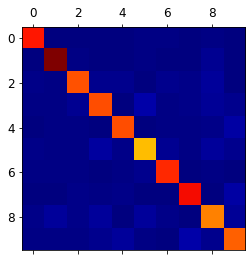

In [64]:
#We can also plot the confusion matrix to get a clearer view instead of a numerical matrix
plt.matshow(conf_mx, cmap=plt.get_cmap("jet"))
plt.show()

In [65]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

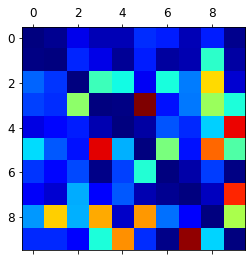

In [66]:
#We can focus on plot erros by dividing each value in the confusion matrix by the number of images in the corresponding
#class so we can compare error rates instead of absolut numer of errors.
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.get_cmap("jet"))
plt.show()
#We can see below that some columns are pretty bright (8 and 9) meaning 8 & 9 are often confused with other digits
#Conversely some rows are pretty dark such a 1 meaning most 1s are classified correctly

#The below tells us that we need to focus on improving classification of 8s and 9s as well as fixing the specific
#3 and 5 confusion. To do this we could try to gather more training data on these digits, or engineer new features
#that would hepl the classifier for example, writing an algorithm to count the number of closed loops. Or we could
#preprocess the images to make some patterns stand out more, such as closed loops.

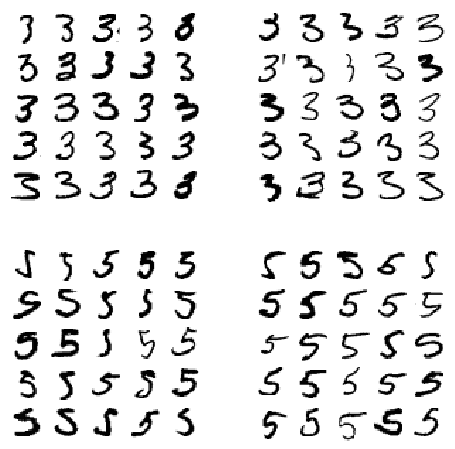

In [67]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()


#We can also plokt and analyze individual erros to gain more insight. 
#Below the two locks on the left show digits classified as 3s and two on the right show digits classified as 5s

#In this instance the model we used, SGD is a simple linear classifier, all it does is assign a weight per class
#to each pixel insensities to get a score for each class. So since 3s and 5s differ only by a few pixels, 
#this model will easily confuse them.

# Multilabel classification


In [101]:
#In some cases we may want the classifier to ouput multiple classes for each instance (recognizing multiple people in a picture)

from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [102]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [103]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

KeyboardInterrupt: 

# Multioutput classification

In [104]:
#Multioutput classification is a generalization of multilabel classification where each label can be multiclass

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

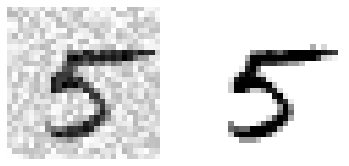

In [115]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

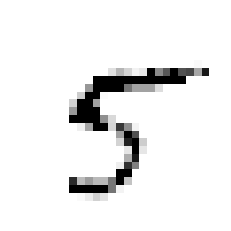

In [116]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)


# KNN Classifier

In [68]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=4, p=2,
                     weights='distance')

In [69]:
y_knn_pred = knn_clf.predict(X_test)

In [70]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

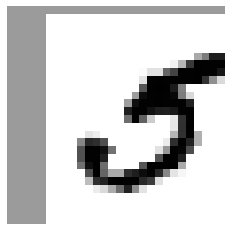

In [71]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [72]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

knn_clf.fit(X_train_expanded, y_train_expanded)

In [74]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [75]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [76]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.       , 0.       , 0.5053645, 0.       , 0.       , 0.       ,
        0.       , 0.4946355, 0.       , 0.       ]])

In [ ]:
plot_digit(ambiguous_digit)

# An MNIST Classifier With Over 97% Accuracy

In [ ]:
#We can use grid search to do parameter tuning for knn
#to improve the accuracy further
from sklearn.model_selection import GridSearchCV

param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = grid_search.predict(X_test)
accuracy_score(y_test, y_pred)

# Data Augmentation

In [ ]:
#We can also augment the data to try and improve accuracy
#by shifting the digits
from scipy.ndimage.interpolation import shift

In [ ]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
    return shifted_image.reshape([-1])

In [ ]:
image = X_train[1000]
shifted_image_down = shift_image(image, 0, 5)
shifted_image_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title("Original", fontsize=14)
plt.imshow(image.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down", fontsize=14)
plt.imshow(shifted_image_down.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left", fontsize=14)
plt.imshow(shifted_image_left.reshape(28, 28), interpolation="nearest", cmap="Greys")
plt.show()

In [ ]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [ ]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [ ]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [ ]:
knn_clf.fit(X_train_augmented, y_train_augmented)

In [ ]:
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)